# DSPy для OCR

Сегодня мы на практике познакомимся с фреймворком DSPy (Declarative Self-improving Python). Наша задача проста: у нас есть фотография ценника, и мы хотим, чтобы нейросеть автоматически нашла на нем цену, название товара и дату.

Для этого мы будем использовать мультимодальную модель LLM.

Почему именно DSPy?

Обычно, чтобы получить данные от нейросети, нам приходится заниматься "промпт-инжинирингом" подбирать слова, просить модель не писать лишнего, давать ей примеры текстом и т.д Это довольно тонкий и хрупкий процесс.

В DSPy вместо того чтобы писать литературный текст (промт) мы пишем код.

Мы создаем класс (Сигнатуру), где четко указываем: "На входе картинка. На выходе цена (число) и товар (строка)".

DSPy берет эту структуру и сам составляет идеальный запрос к модели. Более того, имея ряд примеров (датасет), есть механизм оптимизации промтов под задачу на основе примеров.

Полезные ссылки:

* [Официальная документация DSPy](https://dspy.ai/)

* [Научная статья от Stanford NLP](https://arxiv.org/abs/2310.03714)

* [GitHub репозиторий](https://github.com/stanfordnlp/dspy)

In [ ]:
# Устанавливаем основные библиотеки
!pip install -q attachments dspy-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.0/503.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7

In [ ]:
# # Скачиваем тестовое изображение (кассовый товара)
!wget --no-check-certificate "https://ml.gan4x4.ru/wb/cv/images/cost_badge_1.jpg"

--2026-01-12 21:10:52--  https://ml.gan4x4.ru/wb/cv/images/cost_badge_1.jpg
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 114277 (112K) [image/jpeg]
Saving to: ‘cost_badge_1.jpg’

cost_badge_1.jpg    100%[===================>] 111.60K   204KB/s    in 0.5s    

2026-01-12 21:10:54 (204 KB/s) - ‘cost_badge_1.jpg’ saved [114277/114277]



Здесь мы настраиваем клиент для общения с LLM. Будем использовать быструю и легковесную модель: `gpt-4.1-nano`

In [ ]:
import dspy
import os
from attachments.dspy import Attachments

# Укажите ваш API ключ
os.environ['OPENAI_API_KEY'] = 'YOUR_API_KEY_HERE'

# Инициализация модели
lm_model = dspy.LM("openai/gpt-4.1-nano", cache=False)

# Настраиваем DSPy использовать эту модель по умолчанию для всех модулей
dspy.configure(lm=lm_model)

print(f"✅ Модель {lm_model.model} готова")

✅ Модель openai/gpt-4.1-nano готова


Роль библиотеки Attachments.

LLM не принимают файлы напрямую. Чтобы отправить картинку, вам нужно:

1. Открыть файл в бинарном режиме.

2. Сжать его (если он превышает лимиты токенов/размера).

3. Закодировать байты в строку Base64.

4. Сформировать правильный JSON-объект вида {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,..."}}.

Attachments берет эту рутину на себя. Он создает объект-обертку, который DSPy умеет автоматически встраивать в промпты. Без него пришлось бы писать 15-20 строк кода для обработки кодировок.

* [Репозиторий Attachments](https://pypi.org/project/attachments/)

In [ ]:
image_path = "cost_badge_1.jpg"

# Библиотека сама определит MIME-тип (jpg/png) и закодирует контент
att_list = Attachments(image_path)

print(f"\n✅ Объект подготовлен: {att_list}")

[Attachments] Running primary processor 'image_to_llm' for cost_badge_1.jpg
[Attachments]   Applying step 'load.url_to_response' to cost_badge_1.jpg
[Attachments]   Applying step 'modify.morph_to_detected_type' to cost_badge_1.jpg
[Attachments]   Applying step 'load.image_to_pil' to cost_badge_1.jpg
[Attachments]   Applying step 'modify.watermark' to cost_badge_1.jpg
[Attachments]     Accessing command: 'watermark' = 'auto'
[Attachments]   Running AdditivePipeline(present.images + present.metadata)
[Attachments]     Applying additive step 'present.images' to cost_badge_1.jpg



✅Объект подготовлен: 
## File Info

- **Format**: JPEG
- **Size**: 368 × 450 pixels
- **Mode**: RGB




[Attachments]     Applying additive step 'present.metadata' to cost_badge_1.jpg
[Attachments]   Applying step 'refine.resize_images' to cost_badge_1.jpg


Посмотрим на наш чек:


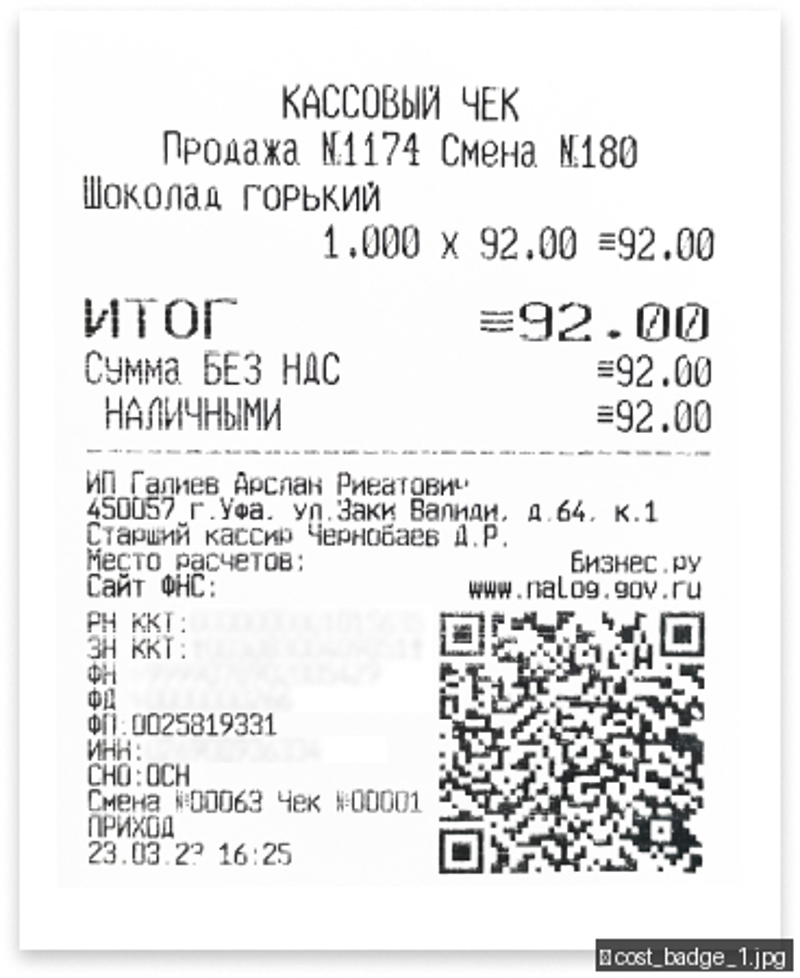

In [ ]:
from IPython.display import HTML
HTML(f"<img src='{att_list[0].images[0]}' width = 600>")

Здесь происходит магия DSPy. Вместо того чтобы подбирать слова для промпта, мы описываем структуру данных, которую хотим получить.

В терминах DSPy это называется Сигнатура (Signature). Представьте, что вы даете модели пустую анкету, которую она должна заполнить:

Что внутри (Docstring): Описание задачи простыми словами. DSPy превратит это в главную инструкцию для модели.

Вход (InputField): То, что мы даем модели (картинка).

Выход (OutputField): То, что модель должна вернуть.

Почему это удобно? Мы используем обычные типы Python (float, str). DSPy сам объяснит модели, что price должно быть числом, а product строкой. Если вы захотите добавить новое поле (например, "валюта"), вам нужно просто добавить одну строчку кода.

In [ ]:
class CostSignature(dspy.Signature):
    """
    Рассмотри изображение ценника.
    Извлеки из него:
    1. Цену товара.
    2. Название товара (или код).
    3. Дату, если она есть.
    """

    # InputField сообщает DSPy, что сюда придут данные (картинка)
    picture: Attachments = dspy.InputField(desc="Фотография ценника товара")

    # OutputField сообщает, что мы ожидаем от модели
    price: float = dspy.OutputField(desc="Цена товара в виде числа с плавающей точкой")
    product: str = dspy.OutputField(desc="Название или код продукта")
    date: str = dspy.OutputField(desc="Дата, указанная на ценнике (если есть)")

Модуль это то, как именно сигнатура будет исполняться. Мы будем использовать `dspy.ChainOfThought` он заставляет модель сначала сгенерировать поле Reasoning (рассуждение), и только потом ответ. [Исследования](https://arxiv.org/abs/2201.11903) показывают, что пошаговое рассуждение значительно улучшает качество ответов в сложных задачах (математика, логика, OCR).


Есть и более простые модули, например `dspy.Predict` (он просто просит модель выдать ответ), полный список модулей в [документации](https://dspy.ai/api/modules/BestOfN/)


In [ ]:
# Оборачиваем сигнатуру в модуль ChainOfThought
cost_extractor = dspy.ChainOfThought(CostSignature)

In [ ]:
# Запускаем обработку
# DSPy сам соберет промпт, добавит картинку в нужном формате и отправит в модель
prediction = cost_extractor(picture=att_list)

print("Рассуждения модели (Reasoning):")
print(prediction.reasoning)

print("\nФинальные предсказания:")
print(f"-Цена: {prediction.price}")
print(f"-Товар: {prediction.product}")
print(f"-Дата: {prediction.date}")

Рассуждения модели (Reasoning):
Кассовый чек

Финальные предсказания:
-Цена: 92.00
-Товар: Шоколад горький
-Дата: 23.03.23


Что на самом деле увидела модель?
Чтобы полностью понять "магию" DSPy, нужно заглянуть под капот. Метод `inspect_history` покажет сырой текст, который ушел в API.

Вы увидите, что DSPy добавил специальные поля и описал все в заданной структуре.


In [ ]:
# Выводим последний запрос и ответ
lm_model.inspect_history(n=1)





[2026-01-12T21:11:08.263784]

System message:

Your input fields are:
1. `picture` (Attachments): Фотография ценника товара
Your output fields are:
1. `reasoning` (str): 
2. `price` (float): Цена товара в виде числа с плавающей точкой
3. `product` (str): Название или код продукта
4. `date` (str): Дата, указанная на ценнике (если есть)
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## picture ## ]]
{picture}

[[ ## reasoning ## ]]
{reasoning}

[[ ## price ## ]]
{price}        # note: the value you produce must be a single float value

[[ ## product ## ]]
{product}

[[ ## date ## ]]
{date}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Рассмотри изображение ценника.
        Извлеки из него:
        1. Цену товара.
        2. Название товара (или код).
        3. Дату, если она есть.


User message:

[[ ## picture ## ]]
## File Info

- **Format**: JPEG
- **Size**: 368 × 450 pixels
- **Mode**: RGB


# Тест на локальной qwen

Давайте проделаем всё то же самое, но используя Ollama, инструмент для запуска открытых моделей. В качестве "мозгов" возьмем Qwen2.5-VL (Vision-Language) — мощную открытую модель от Alibaba, которая отлично понимает картинки.

In [ ]:
# Устанавливаем Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Запускаем сервер Ollama в фоновом режиме
import subprocess
import time

# Запускаем процесс сервера
process = subprocess.Popen(["ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Даем ему 5-10 секунд на загрузку
print("Запускаю сервер Ollama...")
time.sleep(5)

>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tgz
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Запускаю сервер Ollama...


In [ ]:
# Скачиваем модель Qwen2.5-VL (версия 3B быстрая и легкая)
# Используем 'qwen2.5vl:3b' (или актуальный тег для vision модели)
print("Скачиваю модель qwen2.5-vl... Это может занять пару минут.")
!ollama pull qwen2.5vl:3b
print("✅ Готово")

Скачиваю модель qwen2.5-vl... Это может занять пару минут.

✅ Готово


Обратите внимание на формат названия модели: `ollama_chat/qwen2.5vl:3b`. Префикс `ollama_chat/` подсказывает библиотеке, какой протокол общения использовать.

In [ ]:
import dspy
from attachments.dspy import Attachments

# Формат модели для Ollama: 'ollama_chat/<имя_модели>'
lm_model = dspy.LM(
    model='ollama_chat/qwen2.5vl:3b',  # Указываем провайдера и модель
    api_base='http://localhost:11434',  # Адрес локального сервера
    api_key='',  # Для локального Ollama ключ не нужен, но поле обязательно
    timeout=120  # Тайм-аут побольше для vision-моделей
)

# Настраиваем DSPy
dspy.configure(lm=lm_model)

print(f"✅ DSPy успешно подключен к: {lm_model.model}")

✅ DSPy успешно подключен к: ollama_chat/qwen2.5vl:3b


Дальнейший код остается без изменений:

In [ ]:
# Этот код остается без изменений

class CostSignature(dspy.Signature):
    """
    Рассмотри изображение ценника.
    Извлеки из него:
    1. Цену товара.
    2. Название товара (или код).
    3. Дату, если она есть.
    """
    picture: Attachments = dspy.InputField(desc="Фотография ценника товара")
    price: str = dspy.OutputField(desc="Цена товара") # Для слабых моделей лучше использовать str, а не float, чтобы избежать ошибок парсинга
    product: str = dspy.OutputField(desc="Название или код продукта")
    date: str = dspy.OutputField(desc="Дата на ценнике")

# Загружаем картинку
image_path = "cost_badge_1.jpg"
att_list = Attachments(image_path)

# Создаем модуль
cost_extractor = dspy.ChainOfThought(CostSignature)

# Запускаем
print("\nОбработка локальной моделью Qwen...")
prediction = cost_extractor(picture=att_list)

print(f"\nРассуждение: {prediction.reasoning}")
print("\nФинальные предсказания:")
print(f"-Цена: {prediction.price}")
print(f"-Товар: {prediction.product}")
print(f"-Дата: {prediction.date}")

[Attachments] Running primary processor 'image_to_llm' for cost_badge_1.jpg
[Attachments]   Applying step 'load.url_to_response' to cost_badge_1.jpg
[Attachments]   Applying step 'modify.morph_to_detected_type' to cost_badge_1.jpg
[Attachments]   Applying step 'load.image_to_pil' to cost_badge_1.jpg
[Attachments]   Applying step 'modify.watermark' to cost_badge_1.jpg
[Attachments]     Accessing command: 'watermark' = 'auto'
[Attachments]   Running AdditivePipeline(present.images + present.metadata)
[Attachments]     Applying additive step 'present.images' to cost_badge_1.jpg
[Attachments]     Applying additive step 'present.metadata' to cost_badge_1.jpg
[Attachments]   Applying step 'refine.resize_images' to cost_badge_1.jpg



Обработка локальной моделью Qwen...

Рассуждение: Кассовый чек

Финальные предсказания:
-Цена: 92.00
-Товар: Шоколад горький
-Дата: 23.03.23


Мы только что создали полноценное приложение для OCR (распознавания текста), используя современный подход DSPy.

Главные выводы:

* Код надежнее слов. Вместо того чтобы писать длинные текстовые промпты и гадать, поймет ли их модель, мы использовали Сигнатуры (классы Python). Мы только описали что хотим получить (цену, дату).

* Настоящая модульность. Мы заменили облачную модель GPT на локальную Qwen, изменив всего одну настройку в конфигурации. Нам не пришлось переписывать логику кода или менять инструкции. Это делает код гибким и независимым от конкретного провайдера.

* Успех малых моделей. Мы увидели, что даже меленькие модели, справились с задачей. Секрет успеха модуль ChainOfThought, который заставил модель сначала "подумать" и описать увиденное, прежде чем выдавать ответ.

Теперь у вас есть готовый шаблон, который можно адаптировать под любые задачи